In [1]:
import pickle
import numpy as np
import torch
import random
from matplotlib import pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

from lstm_data_prep import prep, numpy_prep
from rnn_perm_test import iterateLSTM, create_permutation_3d
from lstm import test_model_lstm, initialize_lstm

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
with open('HCP_movie_watching.pkl','rb') as f:
    TS = pickle.load(f)

input_size = 300
hidden_size = 32
n_layers = 1
seq_len = 90
class_num = 15

_, test_loader = prep(TS)

In [12]:
lstmModel, lstmOptim, lstmLoss = initialize_lstm(input_size, hidden_size, seq_len)

check = torch.load("lstm-model.pt")
lstmModel.load_state_dict(check["lstm"])
lstmOptim.load_state_dict(check["lstm_optimizer"])

lstmModel.eval()

lstm_accuracy = test_model_lstm(lstmModel, test_loader, lstmLoss, seq_len)

In [21]:
# Run permutation test on model
permutation_lstm_accuracy = iterateLSTM(lstmModel, lstmLoss, TS, num_samples=1)

In [16]:
def generate_random_features(X_lens, num_batches, num_seq = 90, num_features = 300):
    X_random = []
    for i in range(num_batches):
        X_batch = np.random.normal(size=(X_lens[i], num_features))
        if X_lens[i] < num_seq:
            X_pad = np.array([[-100.]*300]*(num_seq - X_lens[i]))
            X_batch = np.append(X_batch, X_pad, axis=0)
        X_random.append(X_batch)
    X_random = np.array(X_random)
    return X_random

def test_random_features(model, loss, dictionary, seq_len = 90, num_samples = 1, batch_size = 32):
    _, _, X, y = numpy_prep(dictionary)
    X_lens = find_lens(X)
    random_features_acc = []
    for i in range(num_samples):
        X_random = generate_random_features(X_lens, X.shape[0])
        X_random_data = TensorDataset(torch.from_numpy(X_random).float(), torch.from_numpy(y).float())
        X_random_loader = DataLoader(X_random_data, shuffle=True, batch_size=batch_size)
        sample_acc = test_model_lstm(model, X_random_loader, loss, seq_len)
        random_features_acc.append(sample_acc)
    return random_features_acc

In [10]:
def find_lens(X):
    X_lens = []
    for batch in X:
        count = 0
        for time in batch:
            if time[0] == -100.:
                break
            else:
                count += 1
        X_lens.append(count)
    return X_lens

In [17]:
rand_acc = test_random_features(lstmModel, lstmLoss, TS)

c:\Users\Anna&Megan\Documents\GitHub\srp-lab-notebook\hcp_data\lstm_data_prep.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_padded = paddingArr(np.array(X_arr))


In [5]:
%store permutation_lstm_accuracy

Stored 'permutation_lstm_accuracy' (ndarray)


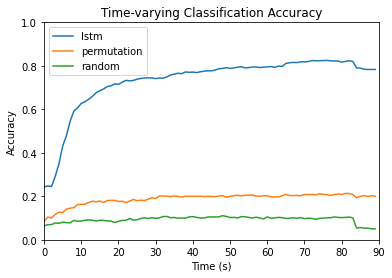

In [22]:
# Compare accuracies
xAx = [i for i in range(0,90)]
plt.plot(xAx, lstm_accuracy, label="lstm")
plt.plot(xAx, permutation_lstm_accuracy, label="permutation")
plt.plot(xAx, rand_acc[0], label="random")
plt.xlabel("Time (s)")
plt.ylabel("Accuracy")
plt.ylim(0,1)
plt.xlim(0,90)
plt.title("Time-varying Classification Accuracy")
plt.legend()
plt.show()

In [7]:
%store lstm_accuracy

Stored 'lstm_accuracy' (ndarray)
